In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


In [2]:
# Set the dataset path
dataset_path = r"F:\BananaRipenessDataset-main\BananaRipenessDataset-main\dataset"

In [3]:
import os
import cv2
import numpy as np

def load_images(dataset_path):
    images = []
    labels = []
    for folder in os.listdir(dataset_path):
        label = folder
        for file in os.listdir(os.path.join(dataset_path, folder)):
            image_path = os.path.join(dataset_path, folder, file)
            
            # Load image
            image = cv2.imread(image_path)
            
            if image is None:
                print(f"Error: Unable to load image '{image_path}'")
                continue
            
            # Preprocess image (normalize, resize, and sharpen)
            normalized_image = image / 255.0
            resized_image = cv2.resize(normalized_image, (224, 224))
            sharpened_image = sharpen_image(resized_image)
            
            images.append(sharpened_image)
            labels.append(label)
    return np.array(images), np.array(labels)

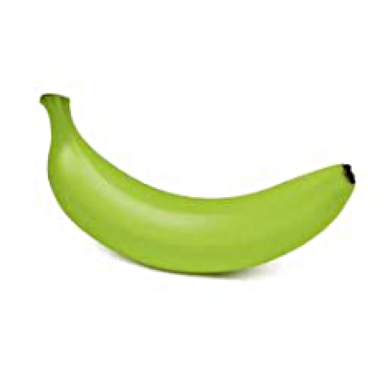

In [4]:
import cv2
import matplotlib.pyplot as plt

def preprocess_and_show_image(image_path):
    # Read image
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Error: Unable to load image '{image_path}'")
        return
    
    # Preprocess image (resize and sharpen)
    resized_image = cv2.resize(image, (224, 224))
    sharpened_image = sharpen_image(resized_image)
    
    # Display preprocessed image
    plt.imshow(cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
    plt.axis('off')
    plt.show()

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

# Example usage:
image_path = r"F:\BananaRipenessDataset-main\BananaRipenessDataset-main\dataset\unripe\ur(1).jpg"  # Replace with the path to your image
preprocess_and_show_image(image_path)


In [5]:
# Load images and labels
images, labels = load_images(dataset_path)

In [6]:
# Preprocessing 1: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [7]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
y_train_one_hot = to_categorical(y_train_encoded, num_classes=3)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=3)

In [8]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    # Convolutional layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    
    # Convolutional layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2,2),
    
    # Convolutional layer 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2,2),
    
    # Flattening the 3D output to 1D
    Flatten(),
    
    # Fully connected layer 1
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    # Output layer
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 128)      

In [10]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_cnn_model1.keras', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Prepare the data augmentation generator for training
train_generator = datagen.flow(X_train, y_train_one_hot, batch_size=32)

# Then, when training the model, use the generator
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=(X_test, y_test_one_hot),  # Make sure your validation data is properly processed
    verbose=2,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)


Epoch 1/25


113/113 - 261s - loss: 0.6895 - accuracy: 0.7631 - val_loss: 0.1143 - val_accuracy: 0.9600 - lr: 0.0010 - 261s/epoch - 2s/step
Epoch 2/25
113/113 - 134s - loss: 0.1755 - accuracy: 0.9350 - val_loss: 0.0812 - val_accuracy: 0.9756 - lr: 0.0010 - 134s/epoch - 1s/step
Epoch 3/25
113/113 - 128s - loss: 0.1375 - accuracy: 0.9528 - val_loss: 0.1637 - val_accuracy: 0.9467 - lr: 0.0010 - 128s/epoch - 1s/step
Epoch 4/25
113/113 - 128s - loss: 0.1460 - accuracy: 0.9489 - val_loss: 0.1017 - val_accuracy: 0.9667 - lr: 0.0010 - 128s/epoch - 1s/step
Epoch 5/25
113/113 - 134s - loss: 0.1447 - accuracy: 0.9500 - val_loss: 0.0565 - val_accuracy: 0.9811 - lr: 0.0010 - 134s/epoch - 1s/step
Epoch 6/25
113/113 - 129s - loss: 0.1206 - accuracy: 0.9586 - val_loss: 0.1213 - val_accuracy: 0.9656 - lr: 0.0010 - 129s/epoch - 1s/step
Epoch 7/25
113/113 - 128s - loss: 0.1147 - accuracy: 0.9614 - val_loss: 0.0619 - val_accuracy: 0.9800 - lr: 0.0010 - 128s/epoch - 1s/step
Epoch 8/25
113/113 - 128s - loss

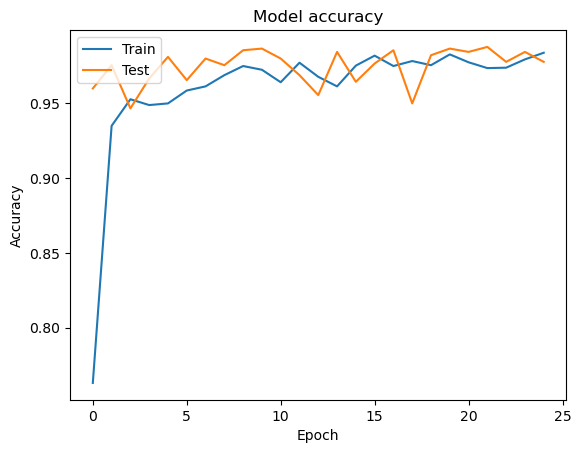

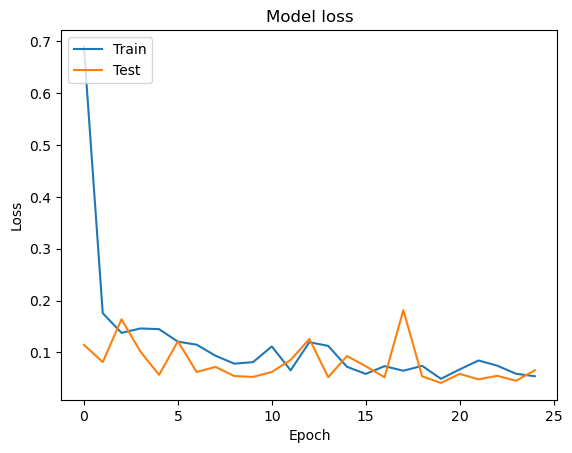

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [12]:
model.evaluate(X_train, y_train_one_hot)

113/113 [==============================] - 64s 196ms/step - loss: 0.0507 - accuracy: 0.9831


[0.05065218359231949, 0.9830555319786072]

In [13]:
model.evaluate(X_test, y_test_one_hot)

29/29 [==============================] - 6s 211ms/step - loss: 0.0654 - accuracy: 0.9778


[0.06538014858961105, 0.9777777791023254]

In [14]:
y_pred =model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_pred

29/29 [==============================] - 8s 181ms/step


array([1, 2, 1, 1, 0, 1, 1, 0, 2, 2, 0, 1, 2, 0, 0, 2, 0, 2, 1, 1, 1, 1,
       2, 2, 2, 0, 1, 0, 2, 0, 2, 2, 0, 2, 2, 2, 1, 1, 2, 2, 0, 0, 1, 2,
       0, 1, 0, 2, 0, 0, 2, 2, 1, 2, 2, 0, 0, 0, 1, 0, 2, 2, 0, 1, 0, 1,
       0, 0, 2, 0, 2, 2, 1, 0, 1, 0, 2, 0, 0, 2, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 2, 0, 2, 2, 0, 1, 0, 2, 1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 2, 0, 2,
       2, 1, 0, 1, 1, 2, 2, 2, 2, 1, 0, 0, 1, 1, 1, 2, 2, 1, 2, 1, 0, 0,
       0, 2, 1, 2, 0, 1, 0, 2, 2, 1, 2, 0, 0, 1, 2, 1, 0, 2, 2, 0, 0, 2,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 2, 1, 2, 2, 0, 0, 2, 2, 1, 0, 2, 0, 0,
       2, 0, 0, 2, 2, 2, 2, 0, 1, 1, 0, 0, 0, 1, 0, 0, 2, 0, 2, 2, 2, 1,
       2, 0, 1, 1, 0, 2, 1, 1, 2, 2, 2, 1, 0, 0, 2, 0, 1, 0, 1, 0, 1, 1,
       2, 2, 2, 2, 1, 0, 2, 2, 0, 0, 2, 2, 1, 0, 2, 2, 2, 2, 1, 0, 1, 1,
       2, 2, 2, 0, 2, 2, 1, 1, 0, 1, 2, 1, 0, 2, 2, 2, 2, 0, 1, 0, 0, 0,
       1, 1, 0, 2, 2, 1, 0, 0, 0, 2, 2, 0, 0, 2, 1, 2, 0, 2, 0, 2, 1, 2,
       1, 1, 0, 1, 0, 2, 0, 1, 2, 2, 1, 2, 1, 1, 0,

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       325
           1       0.94      0.99      0.97       281
           2       1.00      1.00      1.00       294

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900



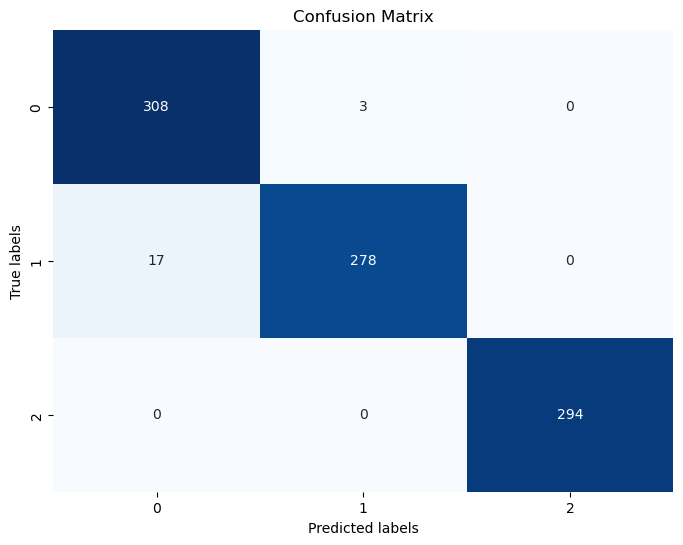

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(y_pred, y_test_encoded))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()